In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



In [3]:
# Load the dataset
df = pd.read_csv('/content/mobile_price_classification.csv')
df.head()

,battery_power,bluetooth,clock_speed,dual_sim,front_cam,4G,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [5]:
# Data Preprocessing
# Features and Labels


X = df.drop('price_range', axis=1)
y = df['price_range']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [6]:
#Building Model
def build_model(hp):
    model = Sequential()

    # Tune number of layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
            activation='relu'
        ))

    # Output layer
    model.add(Dense(4, activation='softmax'))  # 4 classes: 0, 1, 2, 3

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [9]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [10]:
import keras_tuner as kt

In [12]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='mobile_price_ann'
)

tuner.search(X_train, y_train, epochs=20, validation_split=0.2)

# Best model
best_model = tuner.get_best_models(num_models=1)[0]




Trial 10 Complete [00h 00m 45s]
val_accuracy: 0.9234375059604645

Best val_accuracy So Far: 0.9375
Total elapsed time: 00h 05m 00s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
# Training the best model
history = best_model.fit(X_train, y_train, epochs=30, validation_split=0.1)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9862 - loss: 0.1022 - val_accuracy: 0.9062 - val_loss: 0.2149
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9896 - loss: 0.0846 - val_accuracy: 0.9312 - val_loss: 0.2053
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9950 - loss: 0.0754 - val_accuracy: 0.9312 - val_loss: 0.2144
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9946 - loss: 0.0689 - val_accuracy: 0.9438 - val_loss: 0.2082
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0582 - val_accuracy: 0.9250 - val_loss: 0.2006
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0530 - val_accuracy: 0.9312 - val_loss: 0.2102
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0476 - val_accuracy: 0.9312 - val_loss: 0.1940
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0434 - val_accuracy: 0.9312 - val_loss:

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9354 - loss: 0.1515
Test Accuracy: 0.93
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       105
           1       0.90      0.96      0.93        91
           2       0.91      0.91      0.91        92
           3       0.95      0.94      0.94       112

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



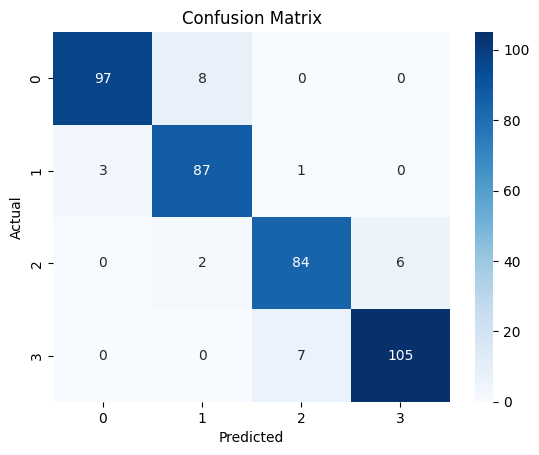

In [15]:


# Evaluate on test data
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Predictions
y_pred = np.argmax(best_model.predict(X_test), axis=-1)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
